We are working towards:

1. object catalog (name of each star in the image)
2. absolute rms motion of the centroid of each object (which is good for figuring out if there are mount/tracking oscillations)
3. differential motion of the centroids of each simultaneously image (here in particular we are curious about the differential rms motion as a function of distance between centroids - kind of like a DIMM)
4. psf of each image -> FWHM + ellipticity or moments
5. scintillation -> change in brightness, as measured with aperture photometry

On Wednesday, May 4 2022, the images are: 219, 226, 227, 228
On Thursday May 5 2022, the images are:
695 to 699
690 to 692
833
836 to 837

relevant images from october 12:
1. 1 s dwell time: 467, 469 - 473
2. 0.5 s dwell time: 475 - 479
3. 1 s dwell time: 482 - 486
4. 0.5 s dwell time: 487 - 491

In [12]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# rsp imports
from lsst.summit.utils.utils import detectSources
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.ip.isr.isrTask import IsrTask

import galsim

from lsst.afw.image import Image
from lsst.geom import Box2I, Point2I, Extent2I
from lsst.meas.extensions import shapeHSM

from scipy.fft import fft

In [104]:
class sttrdImg():
    """Analysis class for stuttered images taken at AuxTel."""
    def __init__(self, expId, shift=50, dwell_time = 1):
        obsdate = int(str(expId)[:8])
        seq_num = int(str(expId)[8:])
        
        self.dataId = {'day_obs': obsdate, 'seq_num': seq_num, 'detector': 0}
        self.exp = self.runIsr()
        
        self.allSources = self.runDetect()
        
        self.shift = shift
        self.dwell_time = dwell_time
        self.pixels = self.exp.image.array.shape
        self.mid = int(self.pixels[0] / 2)
        
        self.cat1, self.cat2 = self.getSpotCat()
        
        self.diff_length = 0
        # make sure catalogs are same length
        if len(self.cat1.index) < len(self.cat2.index):
            self.cat2 = self.cat2[:int(len(self.cat1.index))]
            self.diff_length = int(len(self.cat2.index) - len(self.cat1.index))
        elif len(self.cat2.index) < len(self.cat1.index):
            self.cat1 = self.cat1[:int(len(self.cat2.index))]
            self.diff_length = int(len(self.cat2.index) - len(self.cat1.index))
            
        self.combined = self.makeCombinedCat()
        self.fftCat = self.makeFFTCat()
        self.fft_freq = np.linspace(0, 1/(self.dwell_time * len(self.cat1.index) + 2)* len(self.cat1.index), num = len(self.cat1.index))
        
    def runIsr(self):
        isrConfig = IsrTask.ConfigClass()
        isrConfig.doLinearize = False
        isrConfig.doBias = True
        isrConfig.doFlat = False
        isrConfig.doDark = False
        isrConfig.doFringe = False
        isrConfig.doDefect = True
        isrConfig.doWrite = False
        isrConfig.doSaturation = False
        isrConfig.doNanInterpolation = False
        isrConfig.doNanMasking = False
        isrConfig.doSaturation = False
        isrConfig.doSaturationInterpolation = False
        isrConfig.doWidenSaturationTrails = False
        
        isrTask = IsrTask(config=isrConfig)

        raw = butler.get('raw', self.dataId)
        bias = butler.get('bias', self.dataId)
        defects = butler.get('defects', self.dataId)
        exp = isrTask.run(raw, bias=bias, defects=defects).exposure
        return exp
    
    def runDetect(self):
        sources = detectSources(self.exp.image.array, self.exp.variance.array)
        '''
        # Source measurement
        schema = afwTable.SourceTable.makeMinimalSchema()
        sourceMeasurementTask = SingleFrameMeasurementTask(schema = schema)
        sourceMeasurementTask.run(measCat=sources, exposure=self.exp)
        '''
        return sources
    
    def getSpotCat(self):
        fluxes = np.array([src.flux for src in self.allSources])
        x = np.array([src.x for src in self.allSources])

        # find the series of spots for 2 brightest sources
        max_1 = np.argmax(fluxes)
        x_max = x[max_1]
        spot_1 = np.where(abs(x - x_max) < 10)
        
        flux_max = fluxes[spot_1]
        fluxes[spot_1] = 0
        max_2 = np.argmax(fluxes)
        fluxes[spot_1] = flux_max

        x_max = x[max_2]
        spot_2 = np.where(abs(x - x_max) < 10)
        
        cat1 = self.makeSingleCat(spot_1)
        cat2 = self.makeSingleCat(spot_2)
        
        return cat1, cat2
        
    def makeSingleCat(self, spot):
        xs = np.array([src.x for src in self.allSources])[spot]
        fs = np.array([src.flux for src in self.allSources])[spot]
        ys = np.array([src.y for src in self.allSources])[spot]
        sigmas = np.zeros(len(xs))
        es = np.zeros(len(xs))
        thetas = np.zeros(len(xs))
        
        # sort the spot series
        ys = np.sort(ys)
        index = np.linspace(0,len(ys)-1, len(ys))
        
        # is it in top or bottom half of the image?
        i = np.searchsorted(ys, self.mid)
        if i == len(ys):
            # bottom half, so need to flip order of spots to match direction of time
            ys = ys[::-1]
            xs = xs[::-1]
            fs = fs[::-1]
        elif i != 0:
            # if i==0, top half -> no action required
            # else, problem: not all the spot series is in the same half of the image!
            # plt.figure()
            # plt.imshow(np.arcsinh(10*self.exp.image.array)/10, cmap="magma", origin="lower")
            # plt.show()
            print('both sides of image detected')
            if i > len(ys)/2:
                ys = ys[:i]
                xs = xs[:i]
                fs = fs[:i]
                sigmas = sigmas[:i]
                es = es[:i]
                thetas = thetas[:i]
                # now flip
                ys = ys[::-1]
                xs = xs[::-1]
                fs = fs[::-1]
            else:
                ys = ys[i:]
                xs = xs[i:]
                fs = fs[i:]
                sigmas = sigmas[i:]
                es = es[i:]
                thetas = thetas[i:]
            # raise ValueError('Spot series crossed image midline! Check selection.')
            
        for i in range(len(xs)):
            try:
                galImage = galsim.Image(self.exp.image.array[int(xs[i] - (self.shift/2)):int(xs[i] + self.shift/2),\
                                                                      int(ys[i] - (self.shift/2)):int(ys[i] + (self.shift/2))])
                moments = galsim.hsm.FindAdaptiveMom(galImage, guess_sig = 50)
                sigmas[i] = moments.moments_sigma
                shear = moments.observed_shape
                es[i] = shear.e
                thetas[i] = shear.beta.deg
            except:
                print('No fit: ', i)
                sigmas[i] = -1000
                es[i] = -1000
                thetas[i] = -1000
                
        relys = ys + np.linspace(0, len(ys)-1, num = len(ys)) * self.shift
        relys = relys - relys.mean()
        
        return pd.DataFrame(data=np.array([xs,ys,relys,fs,sigmas,es,thetas]).T, columns=['x','y','relative y','flux','sigma','e','theta'])
    
    
    def makeCombinedCat(self):
        common_x = (self.cat1['x'] + self.cat2['x']) / 2
        common_x = common_x - common_x.mean()
        
        common_y = (self.cat1['relative y'] + self.cat2['relative y']) / 2
        common_y = common_y - common_y.mean()
        diff_x = (self.cat1['x'] - self.cat1['x'].mean()) - (self.cat2['x'] - self.cat2['x'].mean())
        diff_y = (self.cat1['relative y'] - self.cat1['relative y'].mean()) - (self.cat2['relative y'] - self.cat2['relative y'].mean())
        common_flux = 1/2 * (self.cat1['flux'] / self.cat1['flux'].mean() + self.cat2['flux'] / self.cat2['flux'].mean())
        diff_flux = (self.cat1['flux'] / self.cat1['flux'].mean()  - self.cat2['flux'] / self.cat2['flux'].mean())
        
        return pd.DataFrame(data=np.array([common_x,common_y,diff_x,diff_y,common_flux,diff_flux]).T, \
                            columns=['Common x','Common y','Diff x','Diff y','Common flux','Diff flux'])
    
    def makeFFTCat(self):
        FFT_common_x = fft(np.array(self.combined['Common x']))
        FFT_common_y = fft(np.array(self.combined['Common y']))
        FFT_diff_x = fft(np.array(self.combined['Diff x']))
        FFT_diff_y = fft(np.array(self.combined['Diff y']))
        FFT_common_flux = fft(np.array(self.combined['Common flux']))
        FFT_diff_flux = fft(np.array(self.combined['Diff flux']))
        
        return pd.DataFrame(data=np.array([FFT_common_x,FFT_common_y,FFT_diff_x,FFT_diff_y,FFT_common_flux,FFT_diff_flux]).T, \
                            columns=['FFT Common x','FFT Common y','FFT Diff x','FFT Diff y','FFT Common flux','FFT Diff flux'])
                                                             
    
    def display(self, ax, sources=False):
        ax.imshow(np.arcsinh(10*self.exp.image.array)/10, cmap="magma", origin="lower")
        if sources:
            [ax.plot(src.x, src.y, 'wx') for src in self.allSources]
            ax.plot(self.cat1['x'], self.cat1['y'], 'rx')
            ax.plot(self.cat2['x'], self.cat2['y'], 'bx')
            
        
    def plot_motion(self):
        f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

        for cat, color, label in zip([self.cat1, self.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
            y_to_plot = cat['y'] + cat.index*self.shift
            a[0].plot(cat.index, cat['x'] - cat['x'].mean(), 'x', color=color, label=label)
            a[1].plot(cat.index, cat['relative y'], 'x', color=color)

        common_x = self.combined['Common x']
        common_y = self.combined['Common y']

        a[0].plot(self.cat1.index, common_x - common_x.mean(), 'o', color='darkviolet', label='common mode')
        a[1].plot(self.cat1.index, common_y - common_y.mean(), 'o', color='darkviolet')

        a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
        a[0].set_ylabel('x motion')
        a[1].set_ylabel('y motion')

        plt.show()

        f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

        a[0].plot(self.cat1.index, self.combined['Diff x'], \
              'o', color='red', label='differential motion')
        a[1].plot(self.cat1.index, self.combined['Diff y'], \
              'o', color='red')

        a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
        a[0].set_ylabel('x motion')
        a[1].set_ylabel('y motion')

        plt.show()
        


## Close stars

In [93]:
butler = butlerUtils.makeDefaultLatissButler(embargo=True)

# extraWhere = "exposure.observation_type='stuttered'"
# seqNums = butlerUtils.getSeqNumsForDayObs(butler, 20221012, extraWhere=extraWhere)
# seqNums

expid = 2022101200475
img_475 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200476
img_476 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200477
img_477= sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200478
img_478 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200479
img_479 = sttrdImg(expid, dwell_time = 0.5)

No fit:  11
No fit:  30
No fit:  2


No fit:  1
No fit:  30
No fit:  2


No fit:  1
No fit:  14
No fit:  30
No fit:  34
No fit:  2


/home/u/urbach/repos/summit_utils/python/lsst/summit/utils/utils.py:654: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.nanmedian(np.sqrt(variance))


No fit:  1
No fit:  11
No fit:  30
No fit:  2


No fit:  30
No fit:  34
No fit:  2


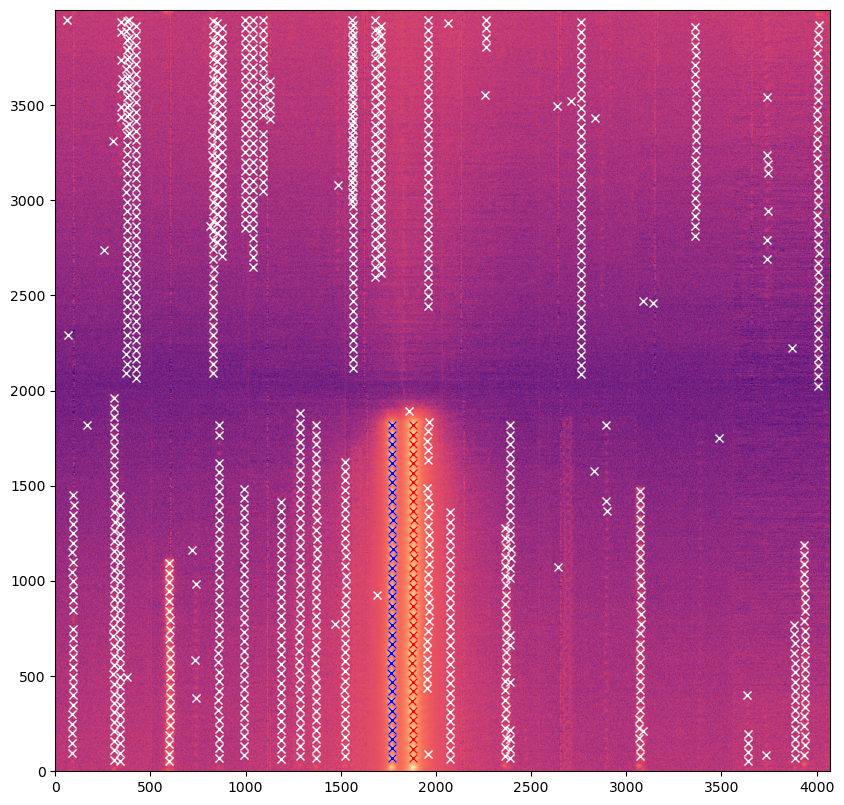

In [94]:
f, ax = plt.subplots(1,1, figsize=(10,10))
img_479.display(ax, sources=True)
plt.show()

Text(0, 0.5, 'Common x FFT')

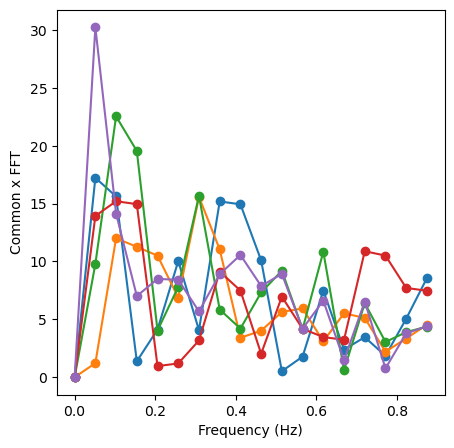

In [95]:
plt.figure(figsize = (5, 5))
N = len(img_475.fft_freq)
plt.plot(img_475.fft_freq[0:N//2], np.abs(img_475.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_476.fft_freq[0:N//2], np.abs(img_476.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_477.fft_freq[0:N//2], np.abs(img_477.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_478.fft_freq[0:N//2], np.abs(img_478.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_479.fft_freq[0:N//2], np.abs(img_479.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common x FFT')

(0.0, 30.0)

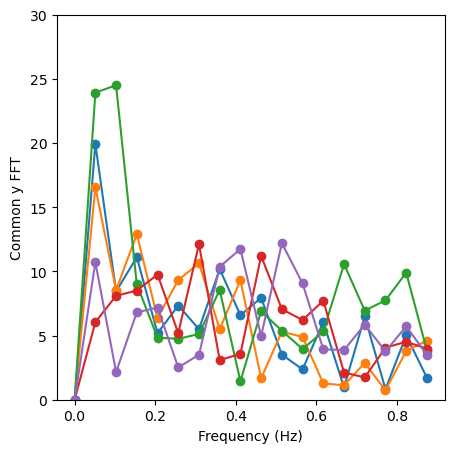

In [96]:
plt.figure(figsize = (5, 5))
N = len(img_475.fft_freq)
plt.plot(img_475.fft_freq[0:N//2], np.abs(img_475.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_476.fft_freq[0:N//2], np.abs(img_476.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_477.fft_freq[0:N//2], np.abs(img_477.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_478.fft_freq[0:N//2], np.abs(img_478.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_479.fft_freq[0:N//2], np.abs(img_479.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common y FFT')
plt.ylim([0, 30])

(0.0, 1.0)

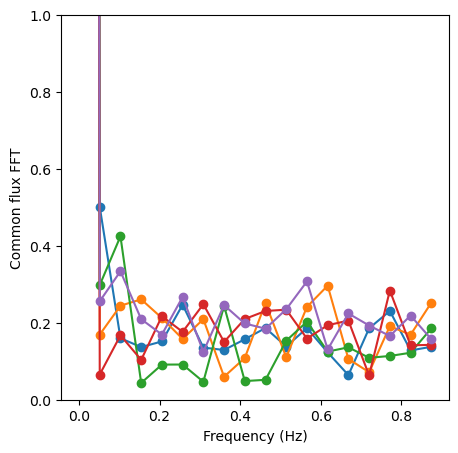

In [97]:
plt.figure(figsize = (5, 5))
N = len(img_475.fft_freq)
plt.plot(img_475.fft_freq[0:N//2], np.abs(img_475.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_476.fft_freq[0:N//2], np.abs(img_476.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_477.fft_freq[0:N//2], np.abs(img_477.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_478.fft_freq[0:N//2], np.abs(img_478.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_479.fft_freq[0:N//2], np.abs(img_479.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common flux FFT')
plt.ylim([0, 1])

Text(0, 0.5, 'Differential x FFT')

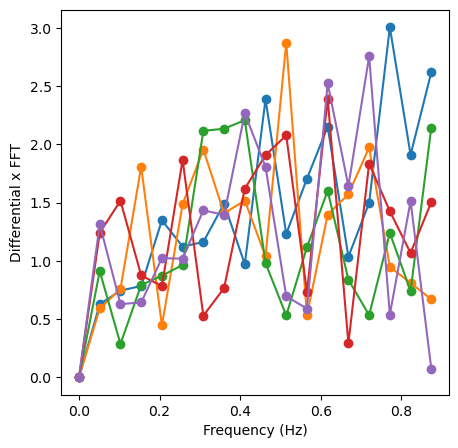

In [98]:
plt.figure(figsize = (5, 5))
N = len(img_475.fft_freq)
plt.plot(img_475.fft_freq[0:N//2], np.abs(img_475.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_476.fft_freq[0:N//2], np.abs(img_476.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_477.fft_freq[0:N//2], np.abs(img_477.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_478.fft_freq[0:N//2], np.abs(img_478.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_479.fft_freq[0:N//2], np.abs(img_479.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Differential x FFT')

Text(0, 0.5, 'Differential y FFT')

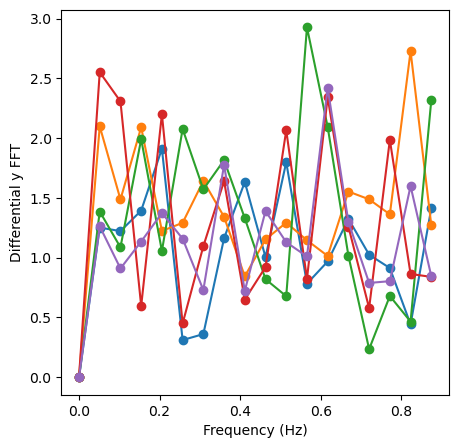

In [99]:
plt.figure(figsize = (5, 5))
N = len(img_475.fft_freq)
plt.plot(img_475.fft_freq[0:N//2], np.abs(img_475.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_476.fft_freq[0:N//2], np.abs(img_476.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_477.fft_freq[0:N//2], np.abs(img_477.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_478.fft_freq[0:N//2], np.abs(img_478.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_479.fft_freq[0:N//2], np.abs(img_479.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Differential y FFT')

In [100]:
print('Image 475')
print('Common x std dev: ', np.std(img_475.combined['Common x']), 'Common y std dev: ', np.std(img_475.combined['Common y']))
print('Differential x std dev: ', np.std(img_475.combined['Diff x']), 'Differential y std dev: ', np.std(img_475.combined['Diff y']))
print('Common flux std dev: ', np.std(img_475.combined['Common flux']), 'Differential flux std dev: ', np.std(img_475.combined['Diff flux']))

print('Image 476')
print('Common x std dev: ', np.std(img_476.combined['Common x']), 'Common y std dev: ', np.std(img_476.combined['Common y']))
print('Differential x std dev: ', np.std(img_476.combined['Diff x']), 'Differential y std dev: ', np.std(img_476.combined['Diff y']))
print('Common flux std dev: ', np.std(img_476.combined['Common flux']), 'Differential flux std dev: ', np.std(img_476.combined['Diff flux']))

print('Image 477')
print('Common x std dev: ', np.std(img_477.combined['Common x']), 'Common y std dev: ', np.std(img_477.combined['Common y']))
print('Differential x std dev: ', np.std(img_477.combined['Diff x']), 'Differential y std dev: ', np.std(img_477.combined['Diff y']))
print('Common flux std dev: ', np.std(img_477.combined['Common flux']), 'Differential flux std dev: ', np.std(img_477.combined['Diff flux']))

print('Image 478')
print('Common x std dev: ', np.std(img_478.combined['Common x']), 'Common y std dev: ', np.std(img_478.combined['Common y']))
print('Differential x std dev: ', np.std(img_478.combined['Diff x']), 'Differential y std dev: ', np.std(img_478.combined['Diff y']))
print('Common flux std dev: ', np.std(img_478.combined['Common flux']), 'Differential flux std dev: ', np.std(img_478.combined['Diff flux']))

print('Image 479')
print('Common x std dev: ', np.std(img_479.combined['Common x']), 'Common y std dev: ', np.std(img_479.combined['Common y']))
print('Differential x std dev: ', np.std(img_479.combined['Diff x']), 'Differential y std dev: ', np.std(img_479.combined['Diff y']))
print('Common flux std dev: ', np.std(img_479.combined['Common flux']), 'Differential flux std dev: ', np.std(img_479.combined['Diff flux']))


Image 475
Common x std dev:  1.47822777035094 Common y std dev:  1.2699321279115034
Differential x std dev:  0.2688453969343664 Differential y std dev:  0.2021365971608591
Common flux std dev:  0.03234503335570299 Differential flux std dev:  0.005862205493790416
Image 476
Common x std dev:  1.2379220727500384 Common y std dev:  1.2280669796587087
Differential x std dev:  0.23985544606647688 Differential y std dev:  0.25139663134533774
Common flux std dev:  0.0325276199697799 Differential flux std dev:  0.007138814123906446
Image 477
Common x std dev:  1.6291773110167604 Common y std dev:  1.7008902434365922
Differential x std dev:  0.21781723639498726 Differential y std dev:  0.2552104167592798
Common flux std dev:  0.02853380488164545 Differential flux std dev:  0.008660017480690754
Image 478
Common x std dev:  1.3833073160716645 Common y std dev:  1.1330706170531315
Differential x std dev:  0.2336977134482236 Differential y std dev:  0.268675517653258
Common flux std dev:  0.03054823

## Far stars

In [105]:
expid = 2022101200487
img_487 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200488
img_488 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200489
img_489= sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200490
img_490 = sttrdImg(expid, dwell_time = 0.5)
expid = 2022101200491
img_491 = sttrdImg(expid, dwell_time = 0.5)

No fit:  18
No fit:  29
No fit:  34
both sides of image detected
No fit:  5
No fit:  8


No fit:  18
No fit:  34
both sides of image detected
No fit:  5
No fit:  8
No fit:  22
No fit:  30


/home/u/urbach/repos/summit_utils/python/lsst/summit/utils/utils.py:654: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.nanmedian(np.sqrt(variance))


both sides of image detected
No fit:  0
No fit:  5
No fit:  8
No fit:  22
No fit:  18
No fit:  28
No fit:  29
No fit:  34


No fit:  18
No fit:  28
No fit:  29
No fit:  34
both sides of image detected
No fit:  0
No fit:  5
No fit:  8
No fit:  22
No fit:  30


No fit:  18
both sides of image detected
No fit:  5
No fit:  8


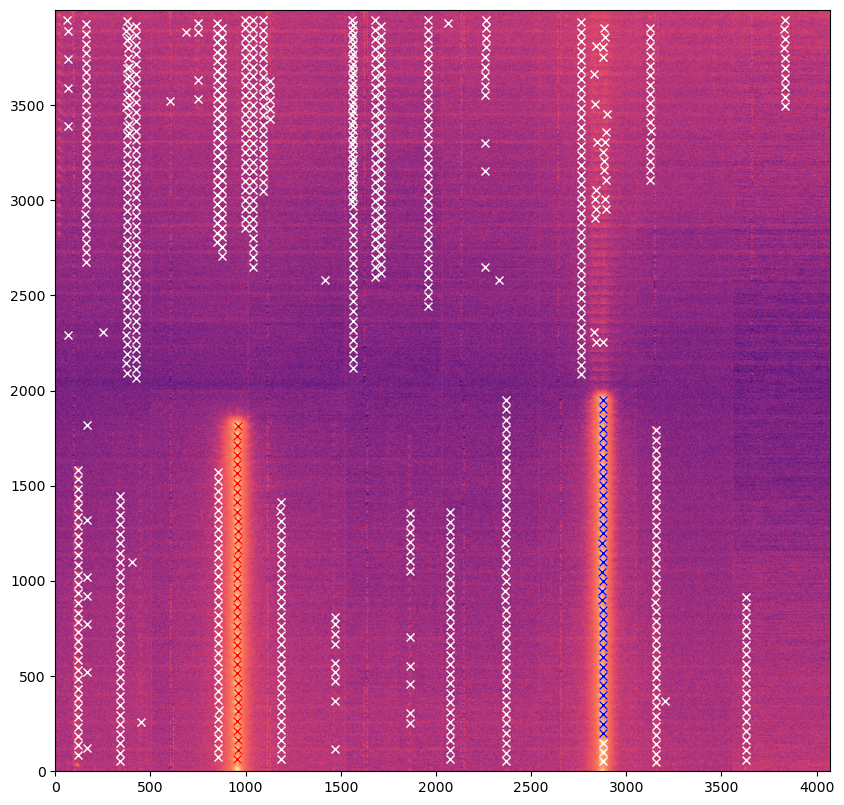

In [106]:
f, ax = plt.subplots(1,1, figsize=(10,10))
img_491.display(ax, sources=True)
plt.show()

Text(0, 0.5, 'Common x FFT')

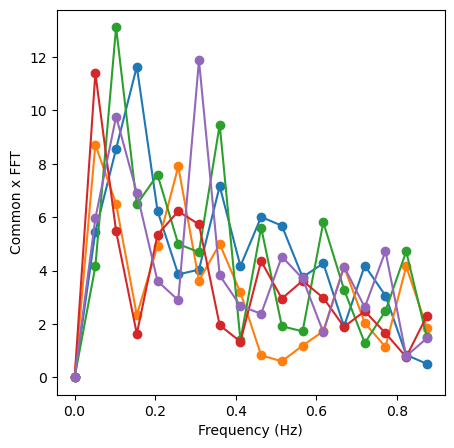

In [107]:
plt.figure(figsize = (5, 5))
N = len(img_487.fft_freq)
plt.plot(img_487.fft_freq[0:N//2], np.abs(img_487.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_488.fft_freq[0:N//2], np.abs(img_488.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_489.fft_freq[0:N//2], np.abs(img_489.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_490.fft_freq[0:N//2], np.abs(img_490.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_491.fft_freq[0:N//2], np.abs(img_491.fftCat['FFT Common x'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common x FFT')

Text(0, 0.5, 'Common y FFT')

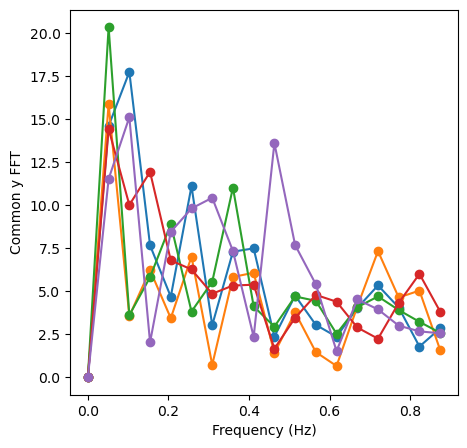

In [108]:
plt.figure(figsize = (5, 5))
N = len(img_487.fft_freq)
plt.plot(img_487.fft_freq[0:N//2], np.abs(img_487.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_488.fft_freq[0:N//2], np.abs(img_488.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_489.fft_freq[0:N//2], np.abs(img_489.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_490.fft_freq[0:N//2], np.abs(img_490.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_491.fft_freq[0:N//2], np.abs(img_491.fftCat['FFT Common y'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common y FFT')

(0.0, 0.5)

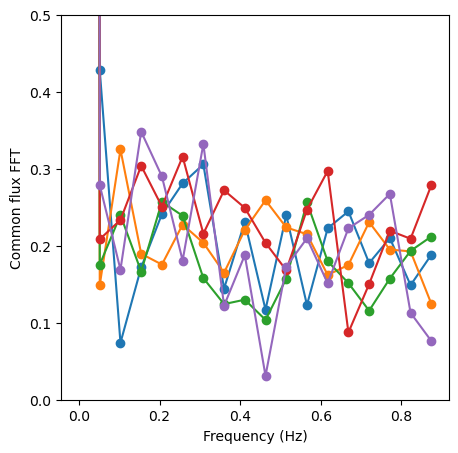

In [113]:
plt.figure(figsize = (5, 5))
N = len(img_487.fft_freq)
plt.plot(img_487.fft_freq[0:N//2], np.abs(img_487.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_488.fft_freq[0:N//2], np.abs(img_488.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_489.fft_freq[0:N//2], np.abs(img_489.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_490.fft_freq[0:N//2], np.abs(img_490.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_491.fft_freq[0:N//2], np.abbs(img_491.fftCat['FFT Common flux'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Common flux FFT')
plt.ylim([0,0.5])

Text(0, 0.5, 'Differential x FFT')

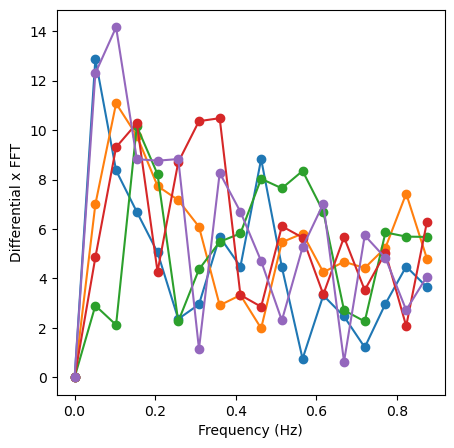

In [115]:
plt.figure(figsize = (5, 5))
N = len(img_487.fft_freq)
plt.plot(img_487.fft_freq[0:N//2], np.abs(img_487.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_488.fft_freq[0:N//2], np.abs(img_488.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_489.fft_freq[0:N//2], np.abs(img_489.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_490.fft_freq[0:N//2], np.abs(img_490.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_491.fft_freq[0:N//2], np.abs(img_491.fftCat['FFT Diff x'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Differential x FFT')


Text(0, 0.5, 'Differential y FFT')

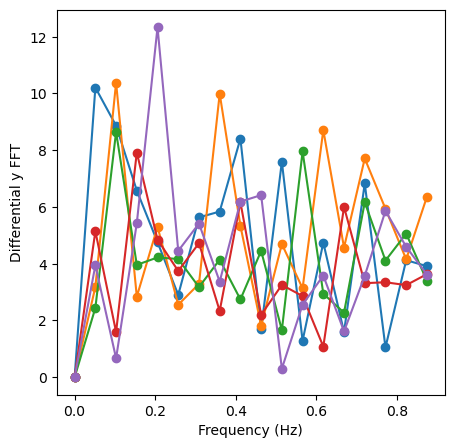

In [117]:
plt.figure(figsize = (5, 5))
N = len(img_487.fft_freq)
plt.plot(img_487.fft_freq[0:N//2], np.abs(img_487.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_488.fft_freq[0:N//2], np.abs(img_488.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_489.fft_freq[0:N//2], np.abs(img_489.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_490.fft_freq[0:N//2], np.abs(img_490.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.plot(img_491.fft_freq[0:N//2], np.abs(img_491.fftCat['FFT Diff y'][0:N//2]), 'o', linestyle = '-')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Differential y FFT')


In [118]:
print('Image 487')
print('Common x std dev: ', np.std(img_487.combined['Common x']), 'Common y std dev: ', np.std(img_487.combined['Common y']))
print('Differential x std dev: ', np.std(img_487.combined['Diff x']), 'Differential y std dev: ', np.std(img_487.combined['Diff y']))
print('Common flux std dev: ', np.std(img_487.combined['Common flux']), 'Differential flux std dev: ', np.std(img_487.combined['Diff flux']))

print('Image 488')
print('Common x std dev: ', np.std(img_488.combined['Common x']), 'Common y std dev: ', np.std(img_488.combined['Common y']))
print('Differential x std dev: ', np.std(img_488.combined['Diff x']), 'Differential y std dev: ', np.std(img_488.combined['Diff y']))
print('Common flux std dev: ', np.std(img_488.combined['Common flux']), 'Differential flux std dev: ', np.std(img_488.combined['Diff flux']))

print('Image 489')
print('Common x std dev: ', np.std(img_489.combined['Common x']), 'Common y std dev: ', np.std(img_489.combined['Common y']))
print('Differential x std dev: ', np.std(img_489.combined['Diff x']), 'Differential y std dev: ', np.std(img_489.combined['Diff y']))
print('Common flux std dev: ', np.std(img_489.combined['Common flux']), 'Differential flux std dev: ', np.std(img_489.combined['Diff flux']))

print('Image 490')
print('Common x std dev: ', np.std(img_490.combined['Common x']), 'Common y std dev: ', np.std(img_490.combined['Common y']))
print('Differential x std dev: ', np.std(img_490.combined['Diff x']), 'Differential y std dev: ', np.std(img_490.combined['Diff y']))
print('Common flux std dev: ', np.std(img_490.combined['Common flux']), 'Differential flux std dev: ', np.std(img_490.combined['Diff flux']))

print('Image 491')
print('Common x std dev: ', np.std(img_491.combined['Common x']), 'Common y std dev: ', np.std(img_491.combined['Common y']))
print('Differential x std dev: ', np.std(img_491.combined['Diff x']), 'Differential y std dev: ', np.std(img_491.combined['Diff y']))
print('Common flux std dev: ', np.std(img_491.combined['Common flux']), 'Differential flux std dev: ', np.std(img_491.combined['Diff flux']))


Image 487
Common x std dev:  0.8888508432065596 Common y std dev:  1.2211703272175067
Differential x std dev:  0.9075162881694163 Differential y std dev:  0.9339147223428566
Common flux std dev:  0.03645139331648944 Differential flux std dev:  0.007582227443946694
Image 488
Common x std dev:  0.6902542375652536 Common y std dev:  0.9415465289277736
Differential x std dev:  1.0298179410682902 Differential y std dev:  0.9494526650329917
Common flux std dev:  0.03389267622377985 Differential flux std dev:  0.007542652886231319
Image 489
Common x std dev:  0.9149427356152429 Common y std dev:  1.1458293344094332
Differential x std dev:  0.9786407036752595 Differential y std dev:  0.7741440126520814
Common flux std dev:  0.03045720560436141 Differential flux std dev:  0.010501499680033903
Image 490
Common x std dev:  0.7268495737478657 Common y std dev:  1.0884287492727438
Differential x std dev:  1.0724160560577467 Differential y std dev:  0.6839995574361196
Common flux std dev:  0.0387598

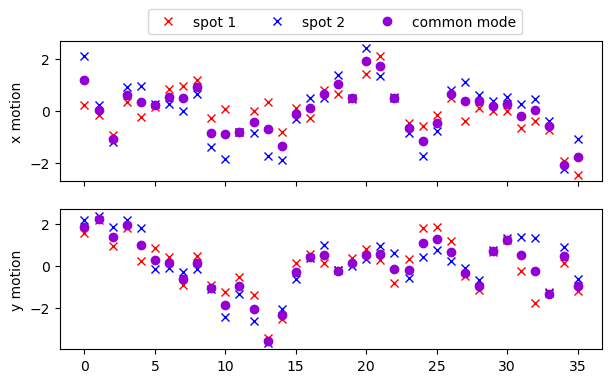

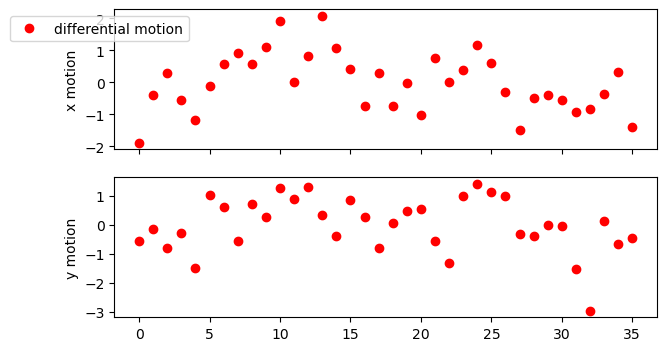

In [116]:
img_487.plot_motion()

## Plots we may not need

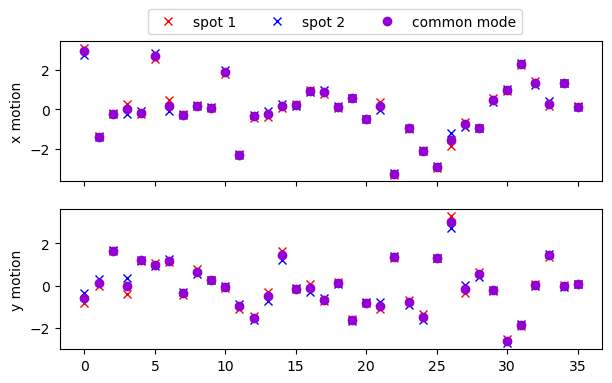

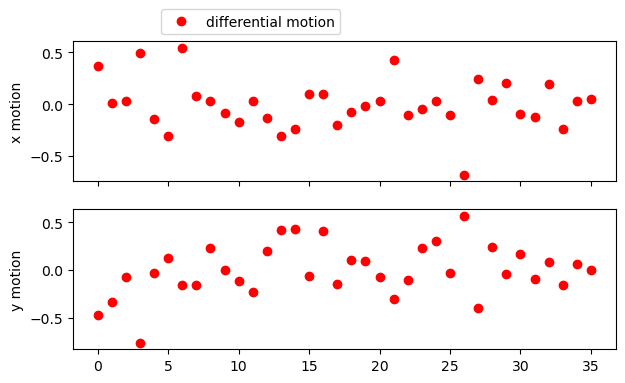

In [27]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

for cat, color, label in zip([img.cat1, img.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
    y_to_plot = cat['y'] + cat.index*img.shift
    a[0].plot(cat.index, cat['x'] - cat['x'].mean(), 'x', color=color, label=label)
    a[1].plot(cat.index, y_to_plot - y_to_plot.mean(), 'x', color=color)

common_x = (img.cat1['x'] + img.cat2['x']) / 2
common_y = (img.cat1['y'] + img.cat2['y']) / 2  + img.cat1.index*img.shift

a[0].plot(img.cat1.index, img_475., 'o', color='darkviolet', label='common mode')
a[1].plot(img.cat1.index, common_y - common_y.mean(), 'o', color='darkviolet')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('x motion')
a[1].set_ylabel('y motion')

plt.show()

f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

a[0].plot(img.cat1.index, (img.cat1['x'] - img.cat1['x'].mean()) - (img.cat2['x'] - img.cat2['x'].mean()), \
          'o', color='red', label='differential motion')
a[1].plot(img.cat1.index, (img.cat1['y'] - img.cat1['y'].mean()) - (img.cat2['y'] - img.cat2['y'].mean()), \
          'o', color='red')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('x motion')
a[1].set_ylabel('y motion')

plt.show()

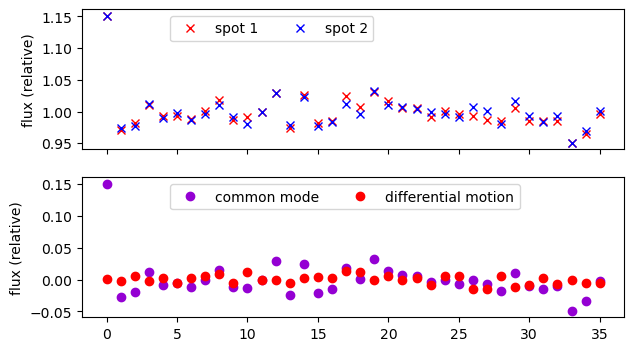

In [28]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

for cat, color, label in zip([img.cat1, img.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
    a[0].plot(cat.index, cat['flux'] / cat['flux'].mean(), 'x', color=color, label=label)

common_flux = 1/2 * (img.cat1['flux'] / img.cat1['flux'].mean() + img.cat2['flux'] / img.cat2['flux'].mean())

a[1].plot(img.cat1.index, common_flux - common_flux.mean(), 'o', color='darkviolet', label='common mode')

a[1].plot(img.cat1.index, (img.cat1['flux'] / img.cat1['flux'].mean()  - img.cat2['flux'] / img.cat2['flux'].mean()), \
          'o', color='red', label = 'differential motion')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[1].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('flux (relative)')
a[1].set_ylabel('flux (relative)')

plt.show()

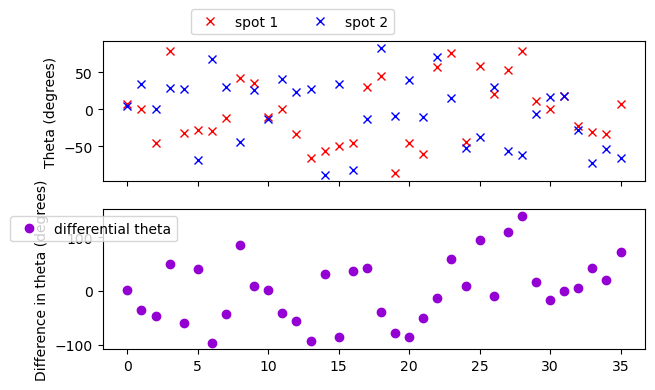

In [29]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

for cat, color, label in zip([img.cat1, img.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
    a[0].plot(cat.index, cat['theta'], 'x', color=color, label=label)

a[1].plot(img.cat1.index, img.cat1['theta'] - img.cat2['theta'], 'o', color='darkviolet', label='differential theta')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[1].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('Theta (degrees)')
a[1].set_ylabel('Difference in theta (degrees)')

plt.show()

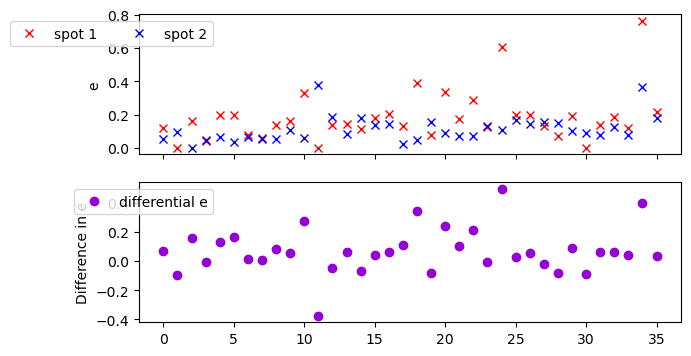

In [30]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

for cat, color, label in zip([img.cat1, img.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
    a[0].plot(cat.index, cat['e'], 'x', color=color, label=label)

a[1].plot(img.cat1.index, img.cat1['e'] - img.cat2['e'], 'o', color='darkviolet', label='differential e')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[1].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('e')
a[1].set_ylabel('Difference in e')

plt.show()

In [69]:
img_487.cat2.index

RangeIndex(start=0, stop=36, step=1)

In [61]:
np.linspace(0, 9, num = 10)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])